# Stock Data Analysis

This notebook analyzes WIG20 stock prices, comparing raw data with smoothed moving averages using different window sizes.


In [ ]:
from src.data import load_prices, smooth_prices

import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)


%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 7)
plt.rcParams["font.size"] = 12

## 1. Load Data

Selected WIG20 companies for analysis: Allegro, CD Projekt, PKO BP.


In [14]:
tickers = ["ALE.WA", "CDR.WA", "PKO.WA"]
prices_df = load_prices(tickers, start="2023-01-01")
prices_df.head()

Ticker,ALE.WA,CDR.WA,PKO.WA
Date,,,
2023-01-02,25.440001,126.949120,26.146084
2023-01-03,26.665001,126.615410,27.433090
2023-01-04,27.000000,125.143127,28.219112
2023-01-05,26.650000,130.109589,28.668270
2023-01-09,28.660000,131.267807,29.739334


## 2. Smoothing and Visualization

Comparison of raw closing prices with moving averages using 7-day and 30-day windows.


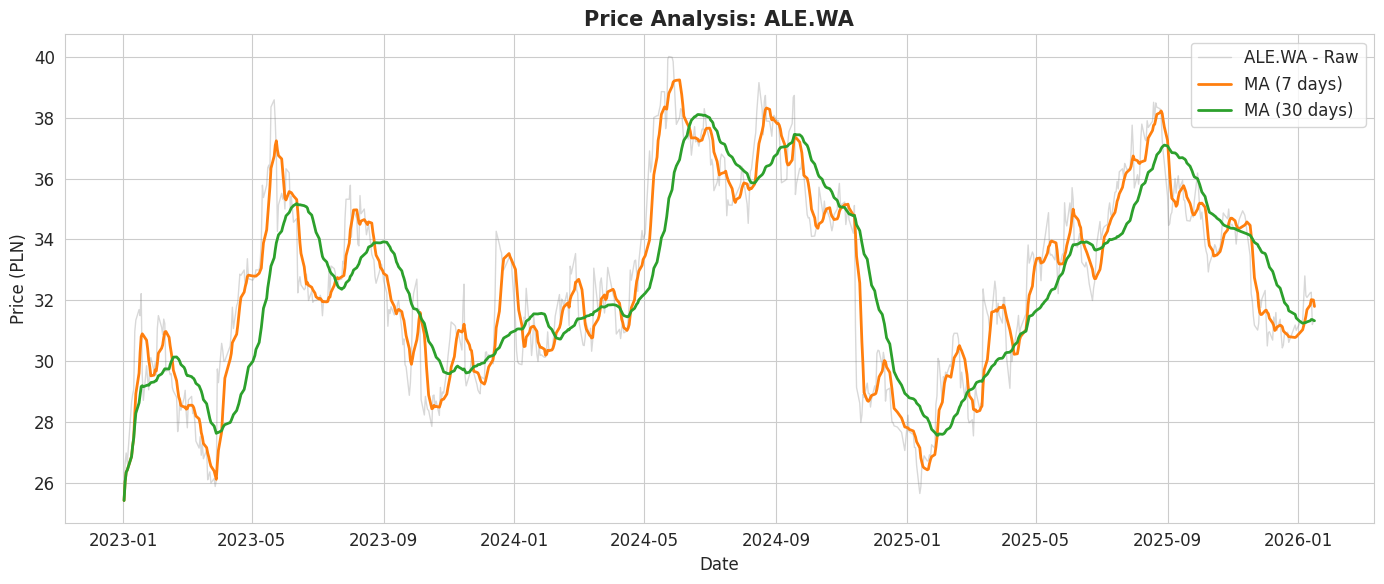

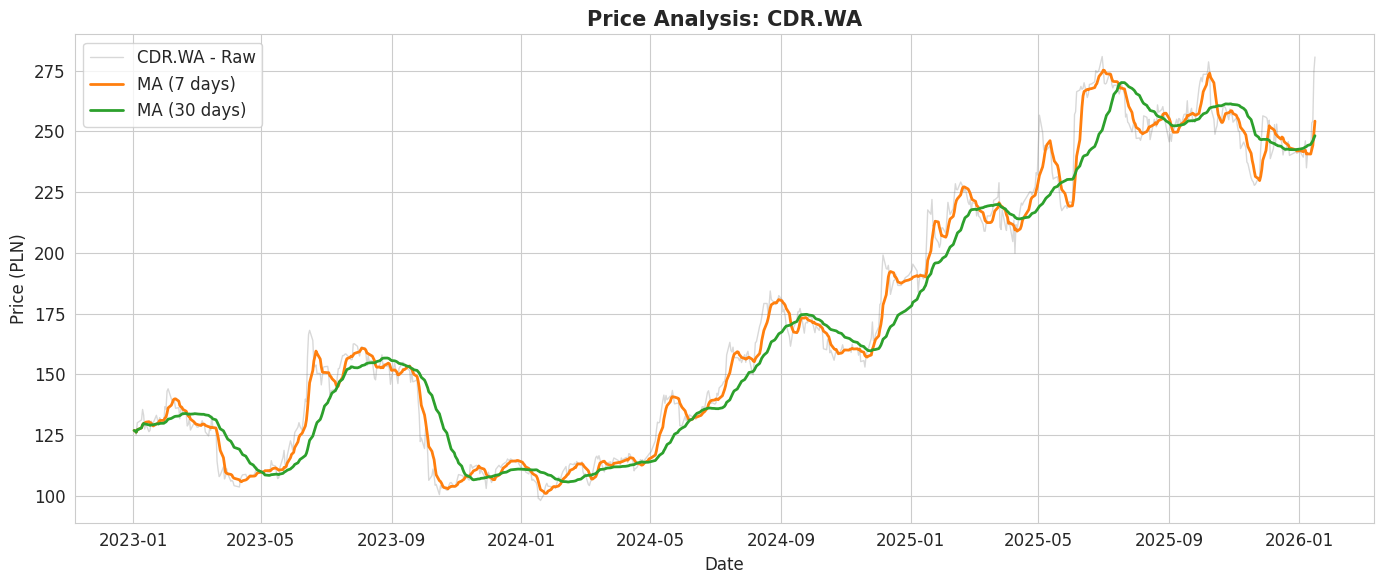

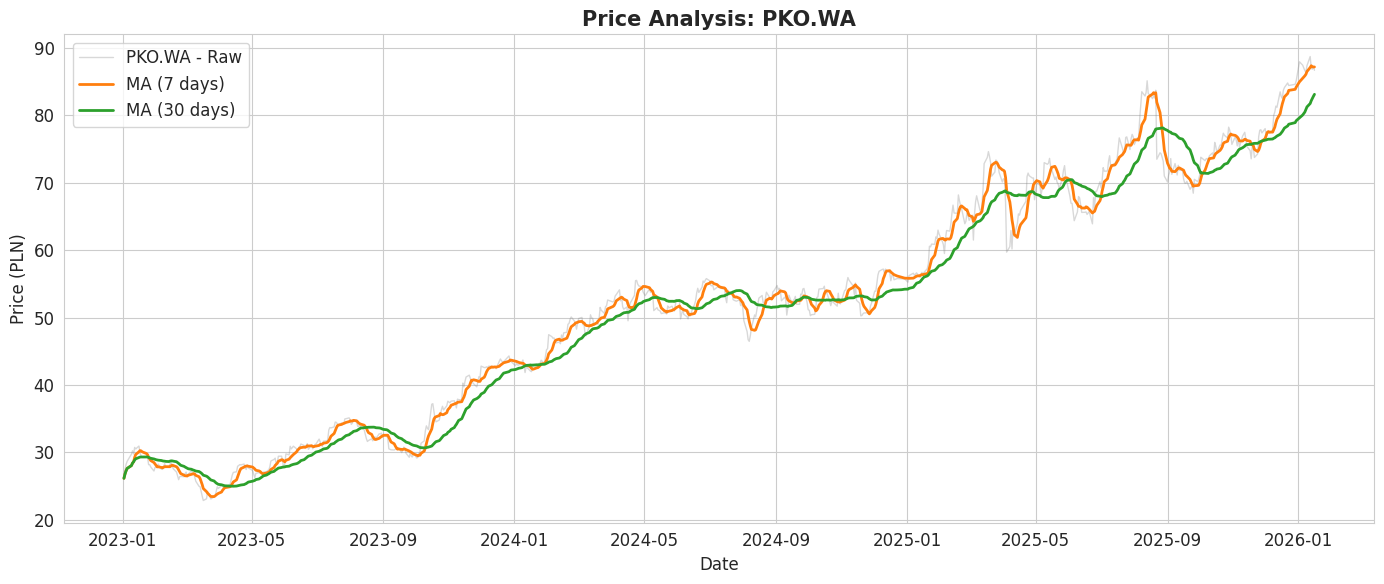

In [15]:
window_sizes = [7, 30]
colors = ["#ff7f0e", "#2ca02c"]

for ticker in tickers:
    plt.figure(figsize=(14, 6))

    raw_prices = prices_df[ticker]
    plt.plot(
        raw_prices.index,
        raw_prices.values,
        label=f"{ticker} - Raw",
        alpha=0.3,
        color="gray",
        linewidth=1,
    )

    for window, color in zip(window_sizes, colors):
        smoothed = smooth_prices(raw_prices, window=window)
        plt.plot(
            smoothed.index,
            smoothed.values,
            label=f"MA ({window} days)",
            linewidth=2,
            color=color,
        )

    plt.title(f"Price Analysis: {ticker}", fontsize=15, fontweight="bold")
    plt.xlabel("Date")
    plt.ylabel("Price (PLN)")
    plt.legend()
    plt.tight_layout()
    plt.show()

## 3. Weekend Interpolation Analysis

Here we visualize how linear interpolation fills the gaps between Friday close and Monday open.
We use three views:

1. **Compressed**: Shows trading days as a sequence (0, 1, 2...), completely removing time gaps. (Top)
2. **Original Data**: Shows the real trading timeline with weekend gaps. (Middle)
3. **Interpolated**: Shows the continuous line with weekends filled in. (Bottom)


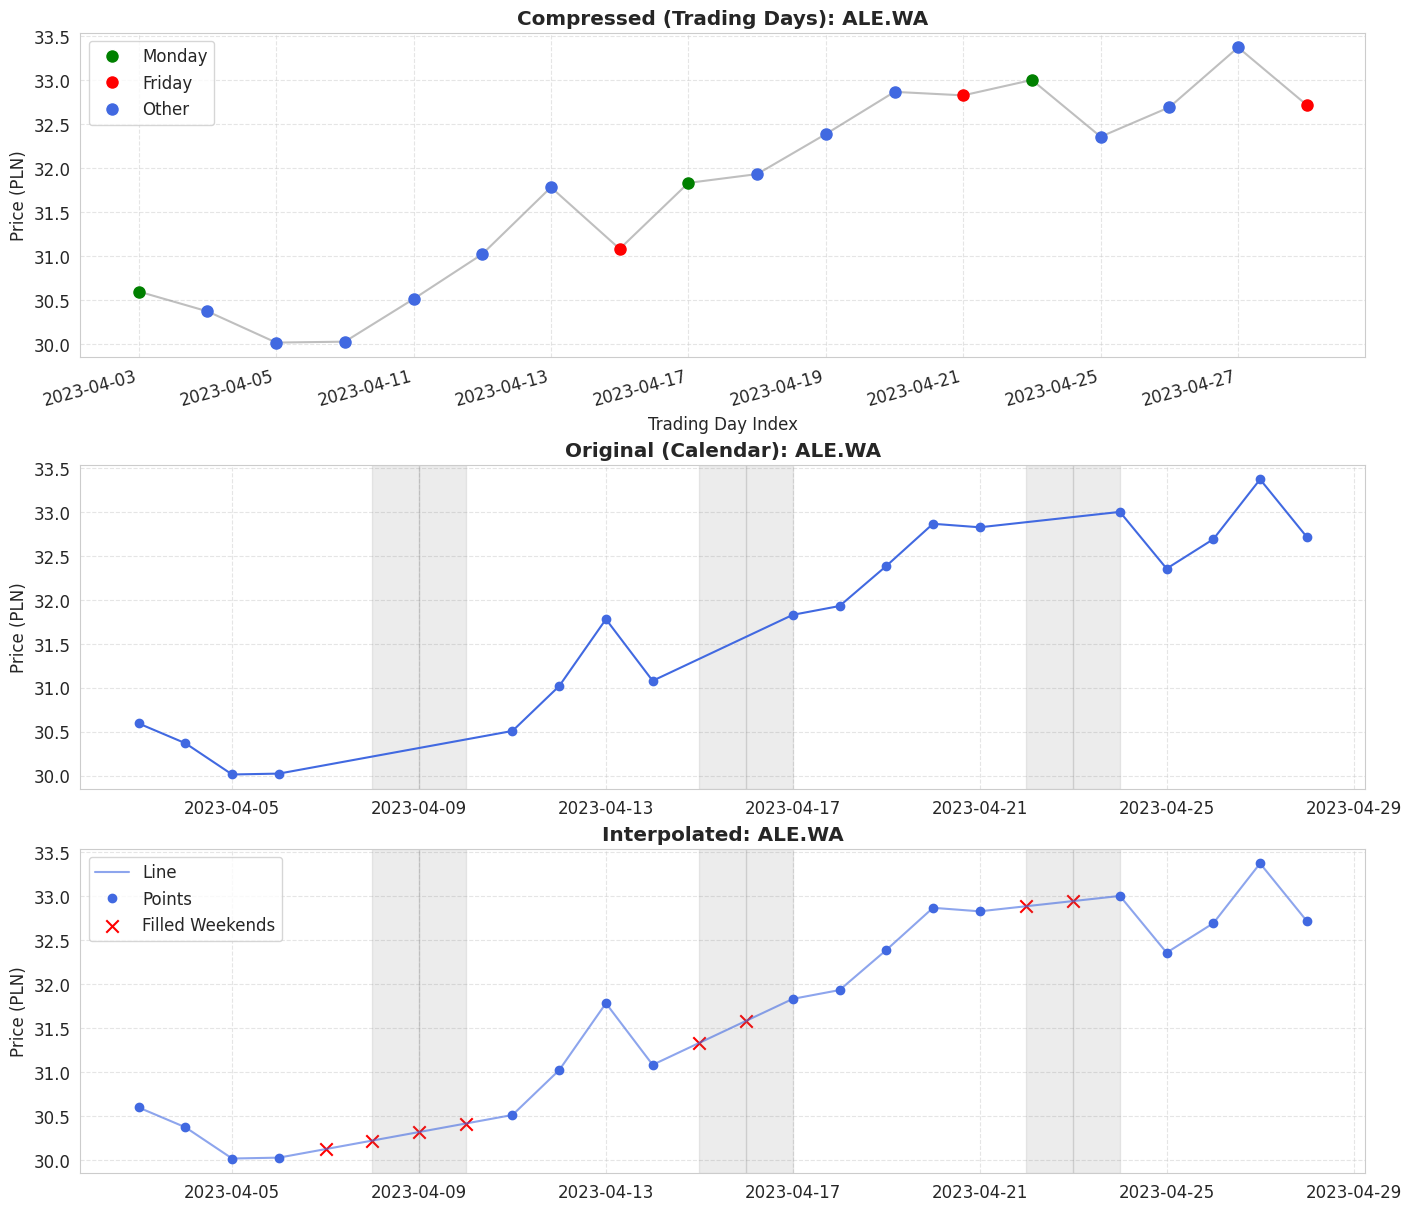

In [ ]:
from src.data import interpolate_weekends

import pandas as pd
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator, FuncFormatter

ticker = "ALE.WA"
start_date, end_date = "2023-04-01", "2023-05-01"

subset_raw = prices_df[ticker][start_date:end_date]
subset_interpolated = interpolate_weekends(subset_raw)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), layout="constrained")
ax3.sharex(ax2)

# --- 1. Compressed Data (Top) ---
ax1.plot(
    np.arange(len(subset_raw)),
    subset_raw.values,
    "-",
    color="gray",
    alpha=0.5,
    label="Trend",
)

# Color logic: Friday=Red, Monday=Green, Others=Blue
days = subset_raw.index.day_name()
cols = ["red" if d == "Friday" else "green" if d == "Monday" else "royalblue" for d in days]

for i, color in enumerate(cols):
    ax1.plot(i, subset_raw.values[i], "o", color=color, markersize=8)


legend_elements = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="green",
        label="Monday",
        markersize=10,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="red",
        label="Friday",
        markersize=10,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor="royalblue",
        label="Other",
        markersize=10,
    ),
]
ax1.legend(handles=legend_elements, loc="upper left")

ax1.set_title(f"Compressed (Trading Days): {ticker}", fontweight="bold")
ax1.set_ylabel("Price (PLN)")
ax1.set_xlabel("Trading Day Index")
ax1.grid(True, linestyle="--", alpha=0.5)


def format_date(x, pos=None):
    idx = int(np.clip(x, 0, len(subset_raw) - 1))
    return subset_raw.index[idx].strftime("%Y-%m-%d")


ax1.xaxis.set_major_locator(MaxNLocator(nbins=10))
ax1.xaxis.set_major_formatter(FuncFormatter(format_date))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=15, ha="right")

# --- 2. Original Data (Middle) ---
ax2.plot(subset_raw.index, subset_raw.values, "o-", color="royalblue", label="Original")
ax2.set_title(f"Original (Calendar): {ticker}", fontweight="bold")
ax2.set_ylabel("Price (PLN)")
ax2.grid(True, linestyle="--", alpha=0.5)

# --- 3. Interpolated Data (Bottom) ---
ax3.plot(
    subset_interpolated.index,
    subset_interpolated.values,
    "-",
    color="royalblue",
    alpha=0.6,
    label="Line",
)
ax3.plot(subset_raw.index, subset_raw.values, "o", color="royalblue", label="Points")

interp_only = subset_interpolated[~subset_interpolated.index.isin(subset_raw.index)]
ax3.scatter(
    interp_only.index,
    interp_only.values,
    color="red",
    marker="x",
    s=80,
    label="Filled Weekends",
)

ax3.set_title(f"Interpolated: {ticker}", fontweight="bold")
ax3.set_ylabel("Price (PLN)")
ax3.grid(True, linestyle="--", alpha=0.5)
ax3.legend(loc="upper left")

# Shade weekends for ax2 & ax3
all_days = pd.date_range(start=subset_raw.index.min(), end=subset_raw.index.max(), freq="D")
weekend_days = [day for day in all_days if day.weekday() >= 5]
for day in weekend_days:
    for ax in [ax2, ax3]:
        ax.axvspan(day, day + pd.Timedelta(days=1), color="gray", alpha=0.15)

plt.show()